# 0. Libary

## 0-1. 설치

In [1]:
!git clone https://github.com/facebookresearch/mae.git

Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39 (from 1)
Unpacking objects: 100% (39/39), 832.30 KiB | 6.71 MiB/s, done.


In [ ]:
!pip install timm==0.4.5

## 0-2. Modules

In [1]:
import sys
import os 
import requests

import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('./mae')

import models_mae

# 0-3. Utils

In [2]:
# Imagenet statistics
imagenet_mean = np.array(([0.485, 0.456, 0.406]))
imagenet_std = np.array([0.229, 0.224, 0.225])

In [3]:
# 시각화 함수
def show_image(image: np.ndarray, title: str ='')-> None:
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')

In [4]:
# 모형 불러오는 함수
def prepare_model(chkpt_dir: str, arch: str ='mae_vit_large_patch16')-> nn.Module:
    # 모형 구축
    model = getattr(models_mae, arch)()
    # 모형 불러오기
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [11]:
# 사진 한 장 추론
def run_one_image(img:np.ndarray, model:nn.Module)-> None:
    x = torch.tensor(img)

    x = x.unsqueeze(0)
    x = torch.einsum('nhwc->nchw', x)

    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # Visualize mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1,1,model.patch_embed.patch_size[0]**2*3)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # Masked image
    img_masked = x * (1-mask)

    # 재구성
    im_paste = x * (1-mask) + y * mask

    # 시각화
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(141)
    show_image(x[0], 'Original')

    plt.subplot(142)
    show_image(img_masked[0], 'Masked')

    plt.subplot(143)
    show_image(y[0], 'Reconstruction')

    plt.subplot(144)
    show_image(im_paste[0], 'Reconstruction + Visible')

    plt.show()

# 1. 추론

## 1-1. 사진 불러오기

/tmp/ipykernel_1505223/976421239.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


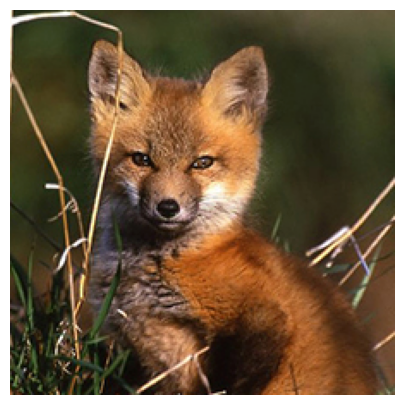

In [6]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## 1-2. 모형 불러오기

In [8]:
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

--2025-07-22 08:26:07--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.168.167.13, 3.168.167.101, 3.168.167.7, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.168.167.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  30.8MB/s    in 41s     

2025-07-22 08:26:49 (30.4 MB/s) - ‘mae_visualize_vit_large.pth’ saved [1318315181/1318315181]



In [7]:
# 가중치 경로
ckpt_dir = './mae_visualize_vit_large.pth'
model = prepare_model(ckpt_dir, 'mae_vit_large_patch16')
print('모형을 불러왔습니다.')

/tmp/ipykernel_1505223/2337188675.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
모형을 불러왔습니다.


## 1-3. 추론

MAE with pixel reconstruction


/tmp/ipykernel_1505223/976421239.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


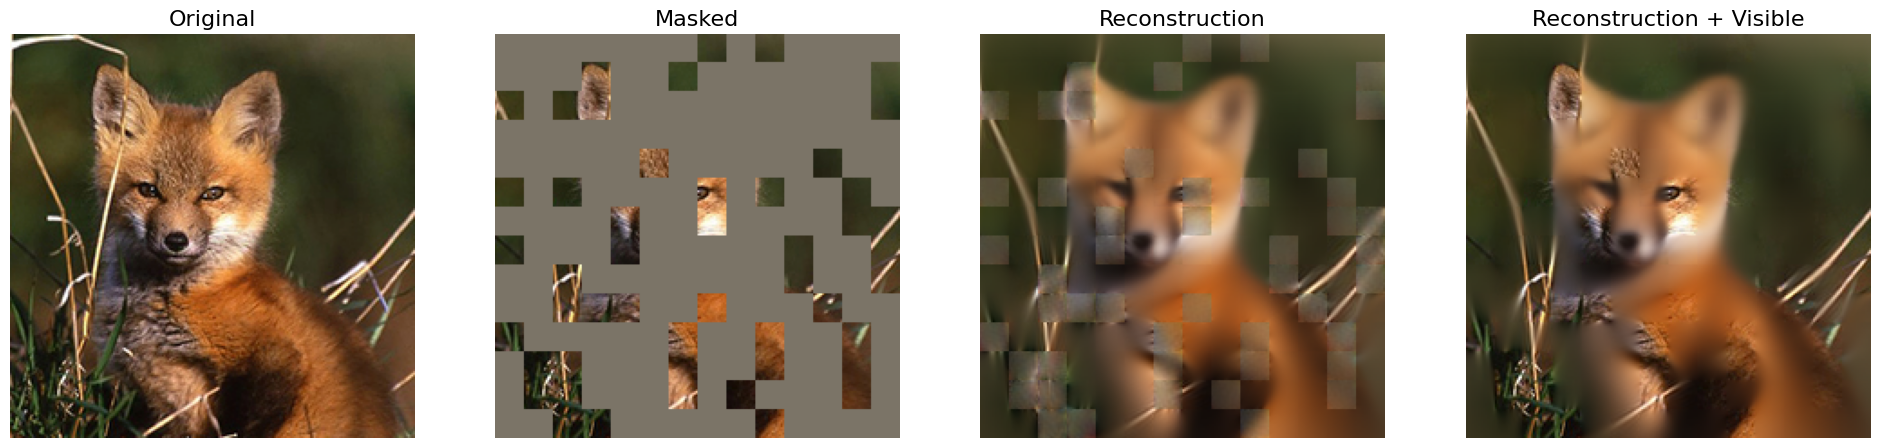

In [12]:
torch.manual_seed(2)
print("MAE with pixel reconstruction")
run_one_image(img, model)